In [136]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns


In [137]:
# Show plots in jupyter notebook
%matplotlib inline


In [138]:
# Set plot style
sns.set(color_codes=True)

In [139]:
PICKLE_TRAIN_DIR = os.path.join("C:/Users/saivi/Documents/BCG", "processed_data", "train_data.pkl")
PICKLE_HISTORY_DIR = os.path.join("C:/Users/saivi/Documents/BCG", "processed_data", "cust_pay.pkl")

In [140]:
history_data = pd.read_pickle(PICKLE_HISTORY_DIR)
train = pd.read_pickle(PICKLE_TRAIN_DIR)

1. FEATURE ENGINEERING

Since we have the consumption data for each of the companies for the year 2015, we will create new features using the average of the year, the
last six months, and the last three months to our model.


In [141]:
mean_year = history_data.groupby(["id"]).mean().reset_index()
mean_6m = history_data[history_data["price_date"] > "2015-06-01"].groupby(["id"]).mean().reset_index()
mean_3m = history_data[history_data["price_date"] > "2015-10-01"].groupby(["id"]).mean().reset_index()


In [142]:
### Combine them in a single dataframe


In [143]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
                                                 "price_p2_var": "mean_year_price_p2_var",
                                                 "price_p3_var": "mean_year_price_p3_var",
                                                 "price_p1_fix": "mean_year_price_p1_fix",
                                                 "price_p2_fix": "mean_year_price_p2_fix",
                                                 "price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [144]:
mean_6m = mean_6m.rename(index=str, columns={"price_p1_var": "mean_6m_price_p1_var",
                                             "price_p2_var": "mean_6m_price_p2_var",
                                             "price_p3_var": "mean_6m_price_p3_var",
                                             "price_p1_fix": "mean_6m_price_p1_fix",
                                             "price_p2_fix": "mean_6m_price_p2_fix",
                                             "price_p3_fix": "mean_6m_price_p3_fix",})
mean_6m["mean_6m_price_p1"] = mean_6m["mean_6m_price_p1_var"] + mean_6m["mean_6m_price_p1_fix"]
mean_6m["mean_6m_price_p2"] = mean_6m["mean_6m_price_p2_var"] + mean_6m["mean_6m_price_p2_fix"]
mean_6m["mean_6m_price_p3"] = mean_6m["mean_6m_price_p3_var"] + mean_6m["mean_6m_price_p3_fix"]


In [145]:
mean_3m = mean_3m.rename(index=str, columns={"price_p1_var": "mean_3m_price_p1_var",
                                             "price_p2_var": "mean_3m_price_p2_var",
                                             "price_p3_var": "mean_3m_price_p3_var",
                                             "price_p1_fix": "mean_3m_price_p1_fix",
                                             "price_p2_fix": "mean_3m_price_p2_fix",
                                             "price_p3_fix": "mean_3m_price_p3_fix",})
mean_3m["mean_3m_price_p1"] = mean_3m["mean_3m_price_p1_var"] + mean_3m["mean_3m_price_p1_fix"]
mean_3m["mean_3m_price_p2"] = mean_3m["mean_3m_price_p2_var"] + mean_3m["mean_3m_price_p2_fix"]
mean_3m["mean_3m_price_p3"] = mean_3m["mean_3m_price_p3_var"] + mean_3m["mean_3m_price_p3_fix"]


In [146]:
#features = pd.merge(mean_year,mean_6m, on="id")
#features = pd.merge(features,mean_3m, on="id")
features = mean_year


Feature Engineering

We will define a variable tenure = date_end - date_activ


In [147]:
train["tenure"] = ((train["date_end"]-train["date_activ"])/ np.timedelta64(1, "Y")).astype(int)


In [148]:
tenure = train[["tenure", "churn", "id"]].groupby(["tenure", "churn"])["id"].count().unstack(level=1)
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)

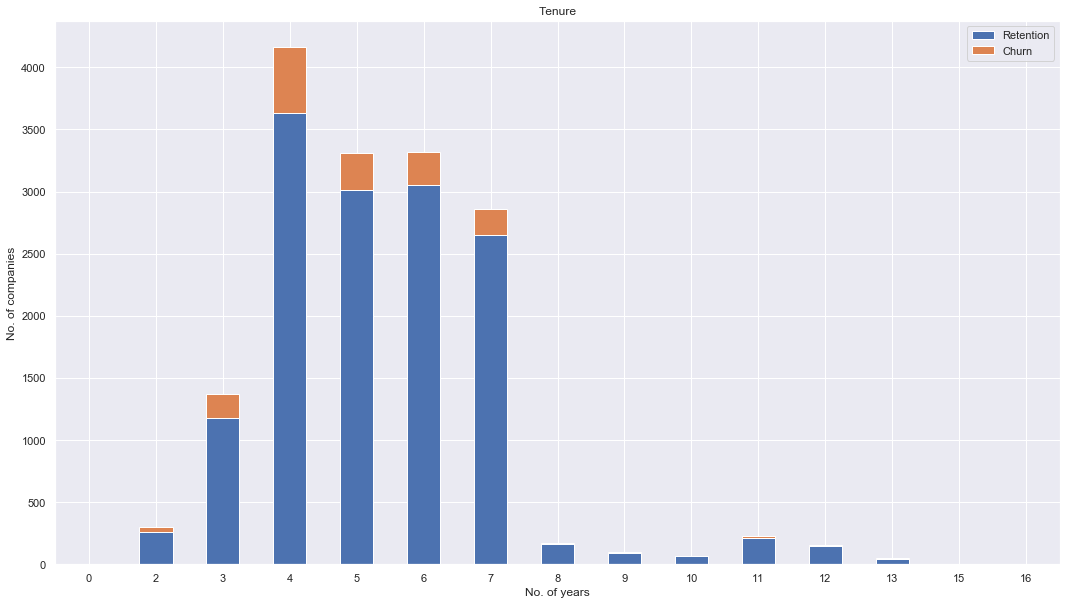

In [149]:
tenure.plot(kind="bar",
 figsize=(18,10),
 stacked=True,
rot=0,
 title= "Tenure")
# Rename legend
plt.legend(["Retention", "Churn"], loc="upper right")
# Labels
plt.ylabel("No. of companies")
plt.xlabel("No. of years")
plt.show()

We can clearly that churn is very low for companies which joined recently or that have made the contract a long time ago. With the higher number of
churners within the 3-7 years of tenure.


We will also transform the dates provided in such a way that we can make more sense out of those.


months_activ : Number of months active until reference date (Jan 2016)
    
    
months_to_end : Number of months of the contract left at reference date (Jan 2016)
    
    
months_modif_prod : Number of months since last modification at reference date (Jan 2016)
    
    
months_renewal : Number of months since last renewal at reference date (Jan 2016)
    
    
To create the month column we will follow a simple process:
    
1. Substract the reference date and the column date

2. Convert the timedelta in months

3. Convert to integer (we are not interested in having decimal months)


In [150]:
def convert_months(reference_date, dataframe, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = REFERENCE_DATE - dataframe[column]
    months = (time_delta / np.timedelta64(1, "M")).astype(int)
    return months


In [151]:
# Create reference date as provided on the exercise statement
REFERENCE_DATE = datetime.datetime(2016,1,1)


In [152]:
train["months_activ"] = convert_months(REFERENCE_DATE, train, "date_activ")
train["months_to_end"] = -convert_months(REFERENCE_DATE, train, "date_end")
train["months_modif_prod"] = convert_months(REFERENCE_DATE, train, "date_modif_prod")
train["months_renewal"] = convert_months(REFERENCE_DATE, train, "date_renewal")


Let's see if we can get any insights

In [153]:
def plot_churn_by_month(dataframe, column, fontsize_=11):
    """
    Plot churn distribution by monthly variable
    """
    temp = dataframe[[column, "churn", "id"]].groupby([column, "churn"])["id"].count().unstack(level=1)
    temp.plot(kind="bar", figsize=(18,10), stacked=True, rot=0, title= column)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc="upper right")
    # Labels
    plt.ylabel("No. of companies")
    plt.xlabel("No. of months")
    # Set xlabel fontsize
    plt.xticks(fontsize=fontsize_)
    plt.show()

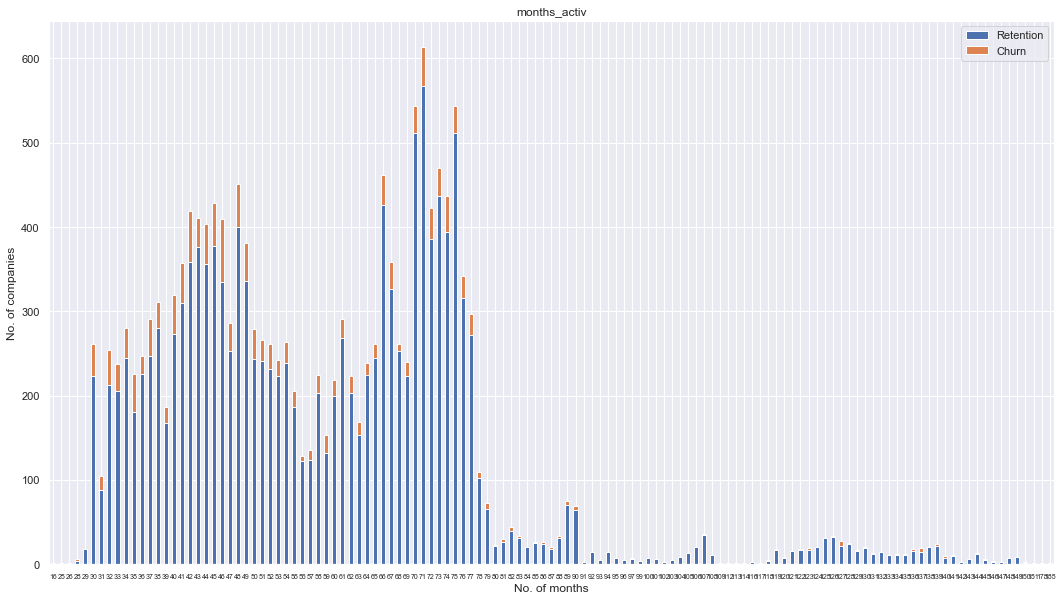

In [154]:
plot_churn_by_month(train, "months_activ", 7)

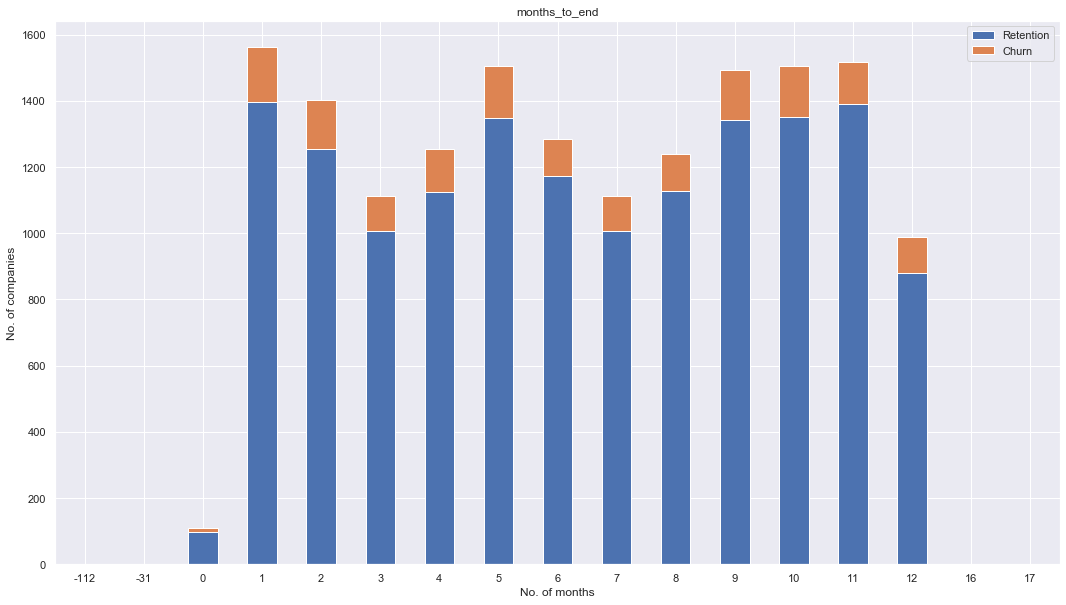

In [155]:
plot_churn_by_month(train, "months_to_end")


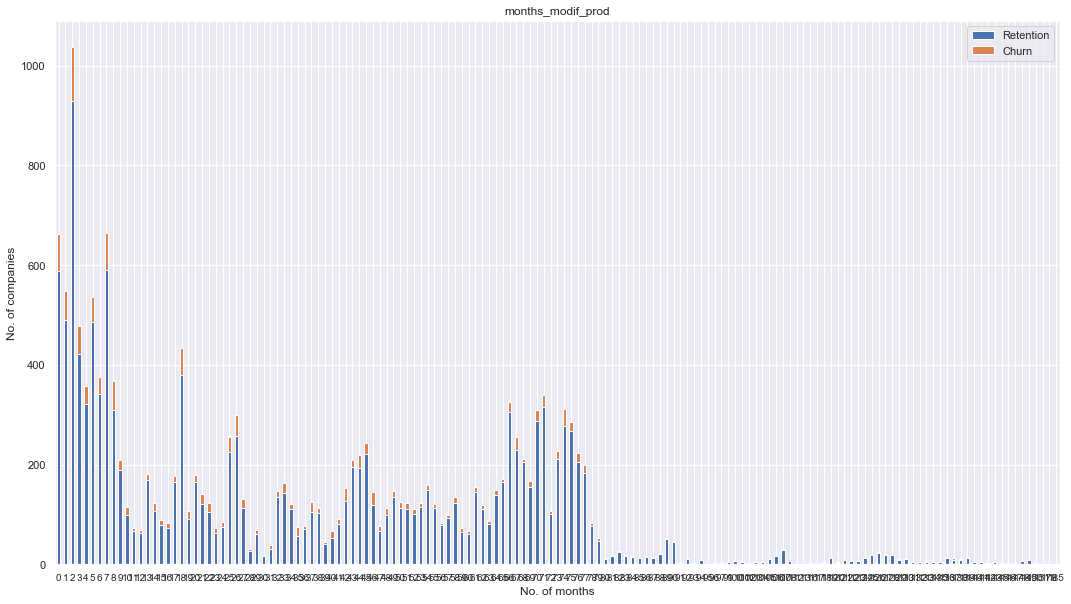

In [156]:
plot_churn_by_month(train, "months_modif_prod", 10)

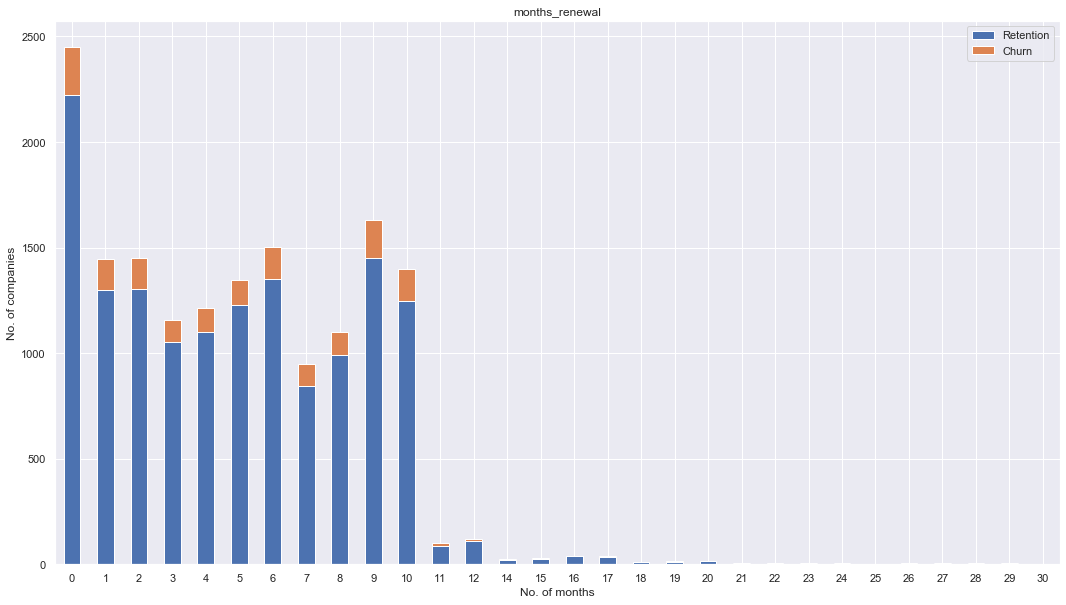

In [157]:
plot_churn_by_month(train, "months_renewal")

In [158]:
train.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"],inplace=True)

Transform Booloean Data

In [159]:
train["has_gas"]=train["has_gas"].replace(["t", "f"],[1,0])

Categorical data and dummy variables

Categorical data --- channel_sales

In [160]:
#First of all let's replace the Nan values with a string called null_values_channel
train["channel_sales"] = train["channel_sales"].fillna("null_values_channel")

In [161]:
# Now transform the channel_sales column into categorical data type
train["channel_sales"] = train["channel_sales"].astype("category")

In [162]:
pd.DataFrame({"Samples in category": train["channel_sales"].value_counts()})

,Samples in category
foosdfpfkusacimwkcsosbicdxkicaua,7377
null_values_channel,4218
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


So that means we will create 8 different dummy variables . Each variable will become a different column.


In [163]:
# Create dummy variables
categories_channel = pd.get_dummies(train["channel_sales"], prefix = "channel")


In [164]:
# Rename columns for simplicity
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]

In [165]:
categories_channel.head(5)

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_nul,channel_sdd,channel_usi
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0


In [166]:
categories_channel.drop(columns=["channel_nul"],inplace=True)


Categorical data origin_up

First of all let's replace the Nan values with a string called null_values_origin

In [167]:
train["origin_up"] = train["origin_up"].fillna("null_values_origin")


In [168]:
#Now transform the origin_up column into categorical data type
train["origin_up"] = train["origin_up"].astype("category")

In [169]:
pd.DataFrame({"Samples in category": train["origin_up"].value_counts()})

,Samples in category
lxidpiddsbxsbosboudacockeimpuepw,7825
kamkkxfxxuwbdslkwifmmcsiusiuosws,4517
ldkssxwpmemidmecebumciepifcamkci,3664
null_values_origin,87
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


In [170]:
# Create dummy variables
categories_origin = pd.get_dummies(train["origin_up"], prefix = "origin")
# Rename columns for simplicity
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]


In [171]:
categories_origin.head(5)


,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_nul,origin_usa
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [172]:
#Finally remove one column to avoid the dummy variable trap

categories_origin.drop(columns=["origin_nul"],inplace=True)

Categorical data - Feature engineering

In [173]:
# First of all let's replace the Nan values with a string called null_values_activity
train["activity_new"] = train["activity_new"].fillna("null_values_activity")

In [174]:
# We want to see how many categories we will end up with
categories_activity = pd.DataFrame({"Activity samples":train["activity_new"].value_counts()})
categories_activity

,Activity samples
null_values_activity,9545
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
...,...
uuxeifdawaobxfxxefkdfxkmsmbfoamf,1
xscbuwcbpwsilaeadffielubxpfpmpxw,1
exmccxcauwolkacaceedipbcmodfedfl,1
aacewucldmklslcffeckexipaemmsdfk,1


In [175]:
# Get the categories with less than 75 samples
to_replace = list(categories_activity[categories_activity["Activity samples"] <= 75].index)
# Replace them with `null_values_categories`
train["activity_new"]=train["activity_new"].replace(to_replace,"null_values_activity")

In [176]:
# Create dummy variables
categories_activity = pd.get_dummies(train["activity_new"], prefix = "activity")
# Rename columns for simplicity
categories_activity.columns = [col_name[:12] for col_name in categories_activity.columns]


In [177]:
categories_activity.head(5)


,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0


In [178]:
categories_activity.drop(columns=["activity_nul"],inplace=True)

Merge dummy variables to main dataframe

In [179]:
# Use common index to merge
train = pd.merge(train, categories_channel, left_index=True, right_index=True)
train = pd.merge(train, categories_origin, left_index=True, right_index=True)
train = pd.merge(train, categories_activity, left_index=True, right_index=True)

In [180]:
train.drop(columns=["channel_sales", "origin_up", "activity_new"],inplace=True)


Log transformation

In [181]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,...,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,...,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,...,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


standard deviation std which is very very high for some variables

Log transformation does not work with negative data, so we will convert the negative values to NaN

Also we cannot apply a log transformation to 0 valued entries, so we will add a constant 1


In [182]:
# Remove negative values
train.loc[train.cons_12m < 0,"cons_12m"] = np.nan
train.loc[train.cons_gas_12m < 0,"cons_gas_12m"] = np.nan
train.loc[train.cons_last_month < 0,"cons_last_month"] = np.nan
train.loc[train.forecast_cons_12m < 0,"forecast_cons_12m"] = np.nan
train.loc[train.forecast_cons_year < 0,"forecast_cons_year"] = np.nan
train.loc[train.forecast_meter_rent_12m < 0,"forecast_meter_rent_12m"] = np.nan
train.loc[train.imp_cons < 0,"imp_cons"] = np.nan


In [183]:
# Apply log10 transformation
train["cons_12m"] = np.log10(train["cons_12m"]+1)
train["cons_gas_12m"] = np.log10(train["cons_gas_12m"]+1)
train["cons_last_month"] = np.log10(train["cons_last_month"]+1)
train["forecast_cons_12m"] = np.log10(train["forecast_cons_12m"]+1)
train["forecast_cons_year"] = np.log10(train["forecast_cons_year"]+1)
train["forecast_meter_rent_12m"] = np.log10(train["forecast_meter_rent_12m"]+1)
train["imp_cons"] = np.log10(train["imp_cons"]+1)

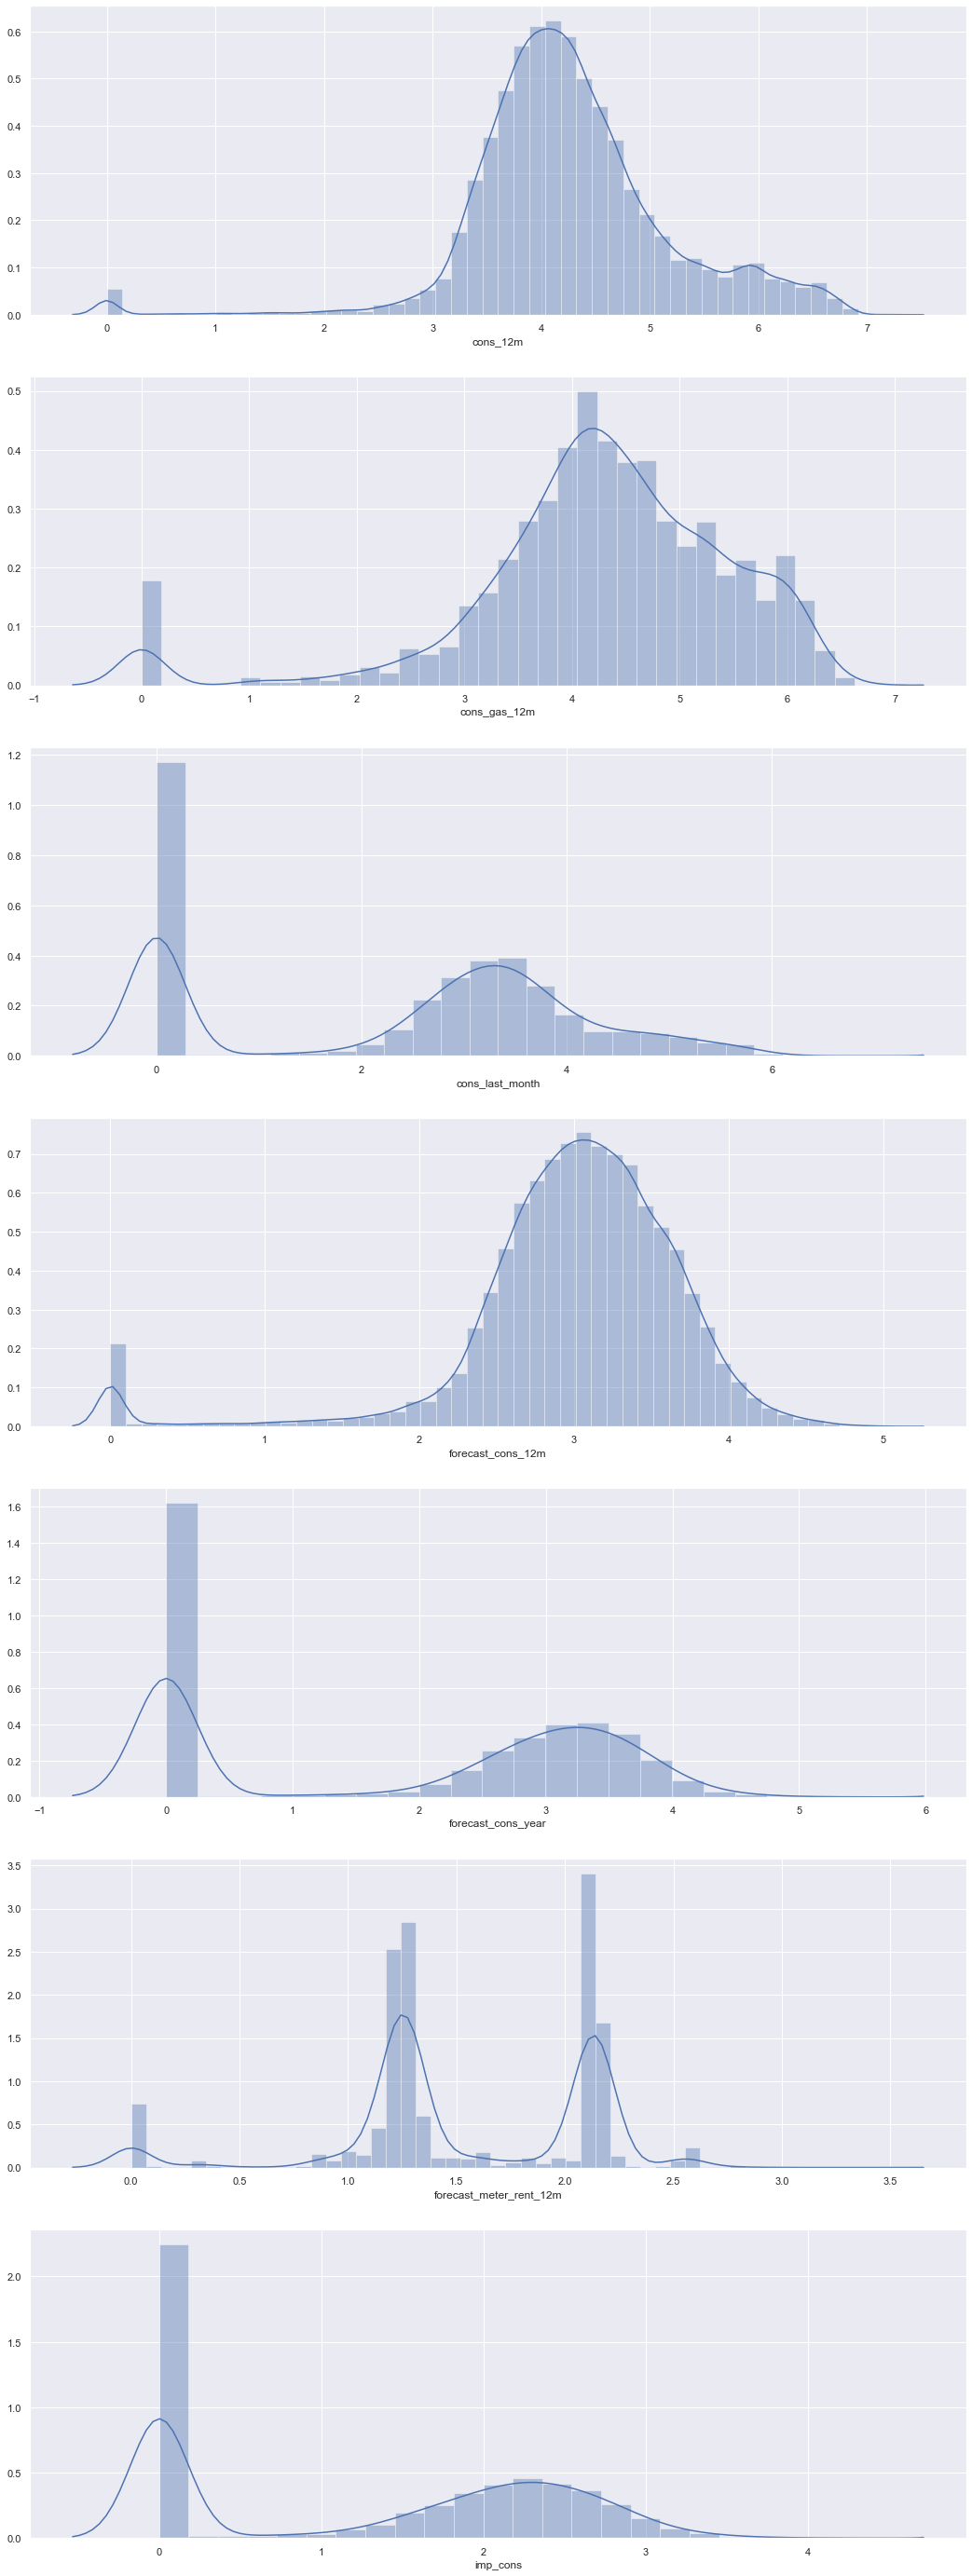

In [184]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot histograms
sns.distplot((train["cons_12m"].dropna()), ax=axs[0])
sns.distplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.distplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.distplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.distplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.distplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

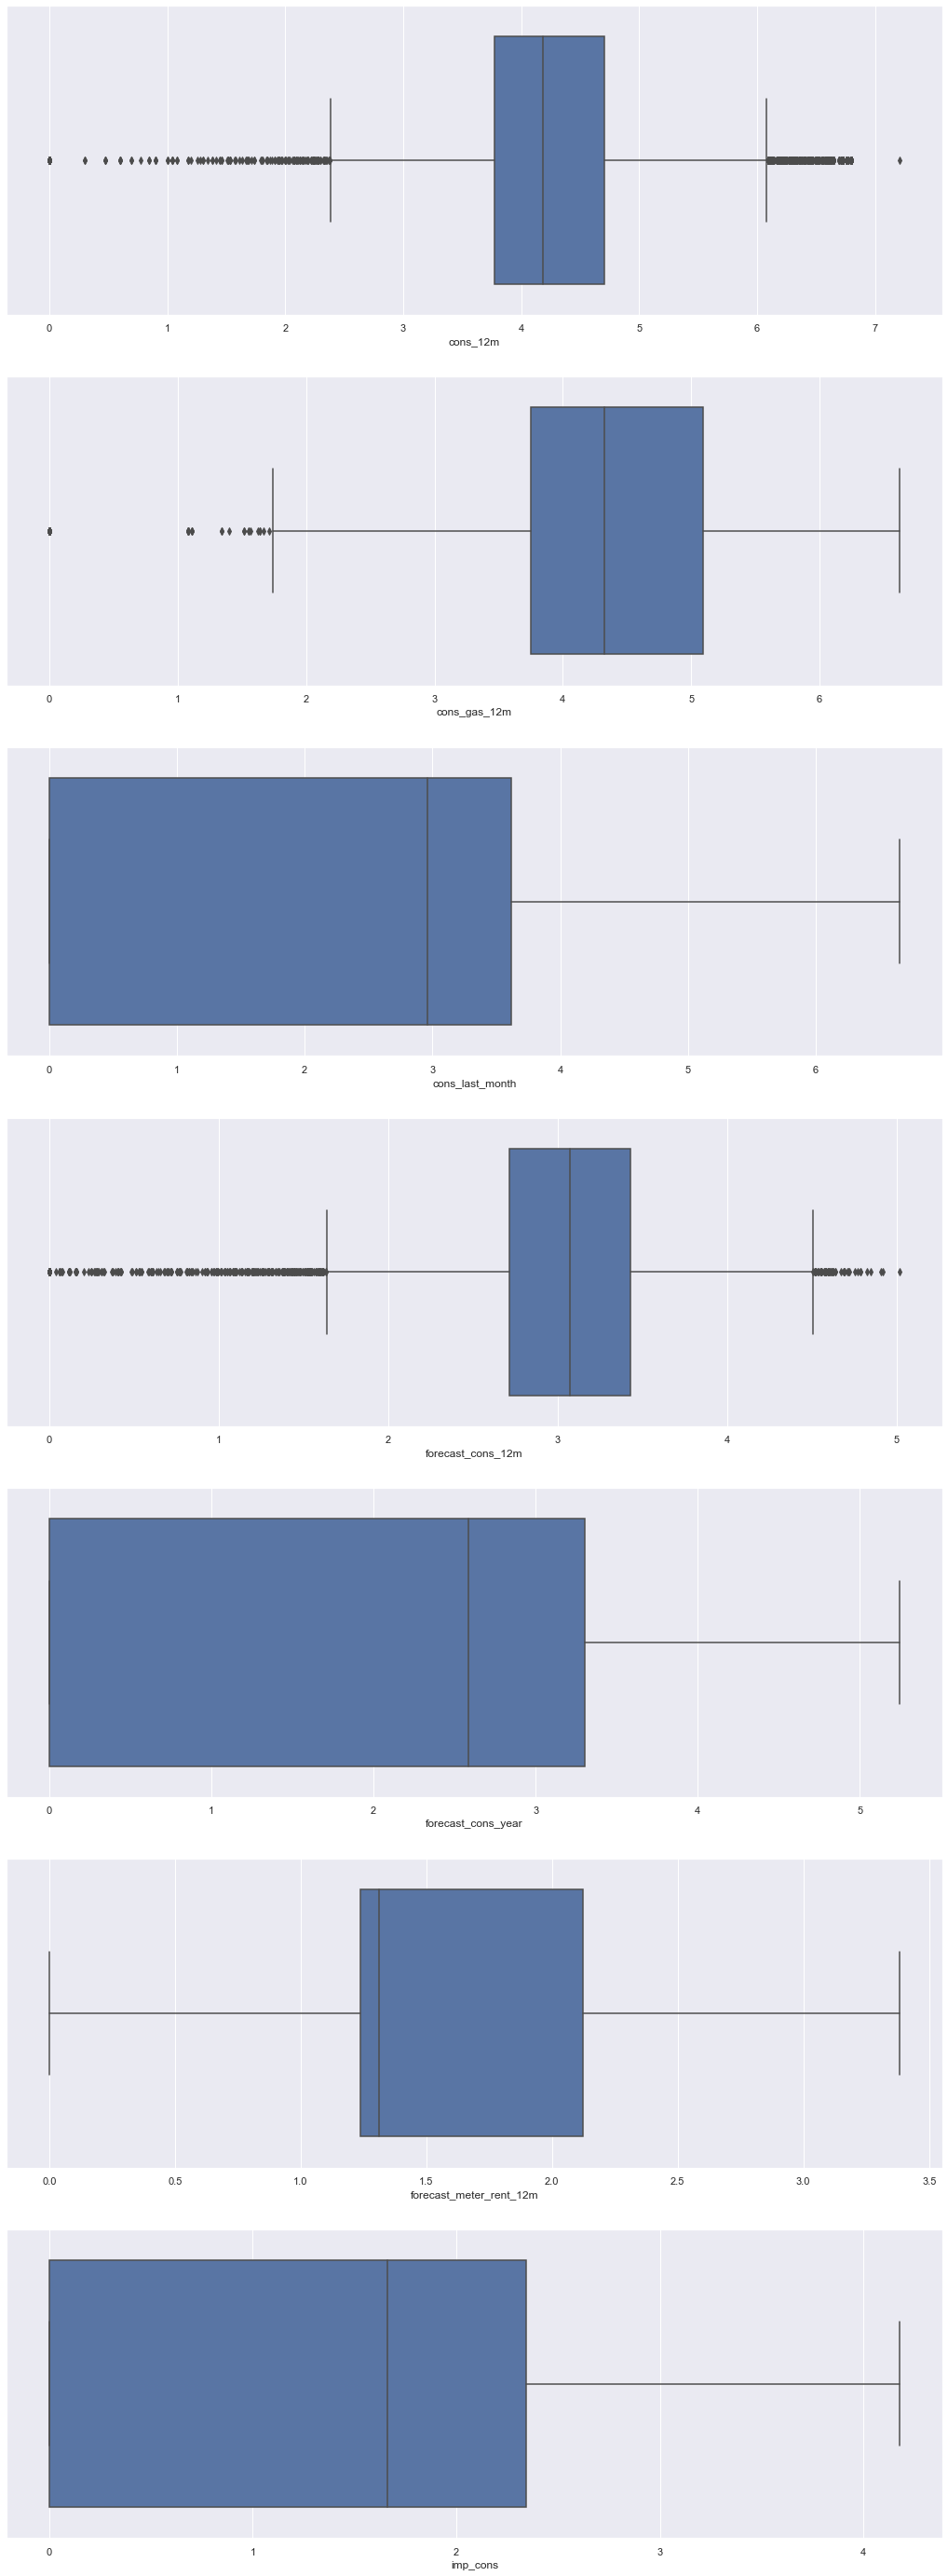

In [185]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [186]:
train.describe()


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,...,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,15970.000000,16092.000000,15970.000000,15970.000000,15970.000000,...,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496,...,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.160969,0.589394,0.026252,0.048617,5.212252,...,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.086163,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The distributions look much closer to normal distributions.

Notice how the standard deviation std has changed.

From the boxplots we can still see some values are quite far from the range ( outliers ). We will deal with them later.


2. High correlation variables

In [187]:
# Calculate correlation of variables
correlation = features.corr()

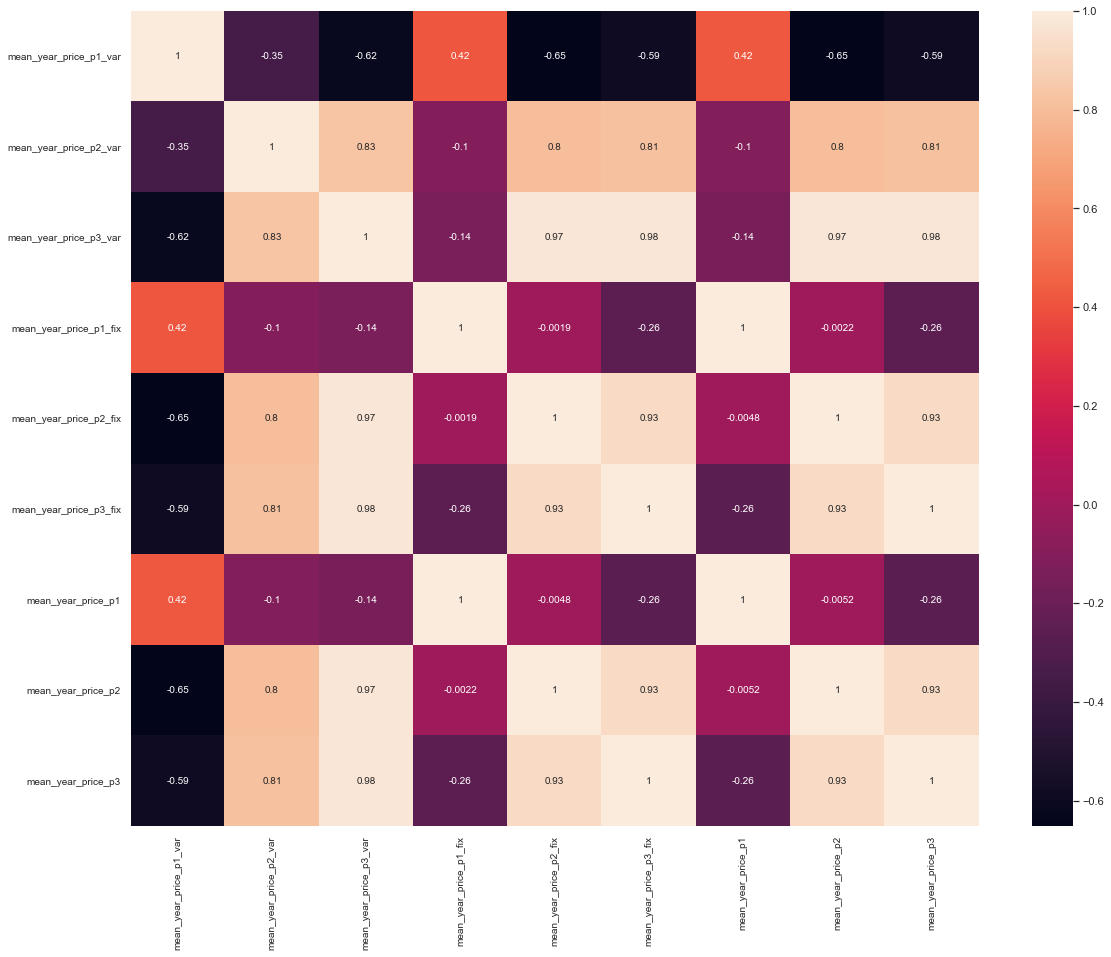

In [188]:
# Plot correlation
plt.figure(figsize=(19,15))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot = True,
            annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [189]:
# Calculate correlation of variables
correlation = train.corr()

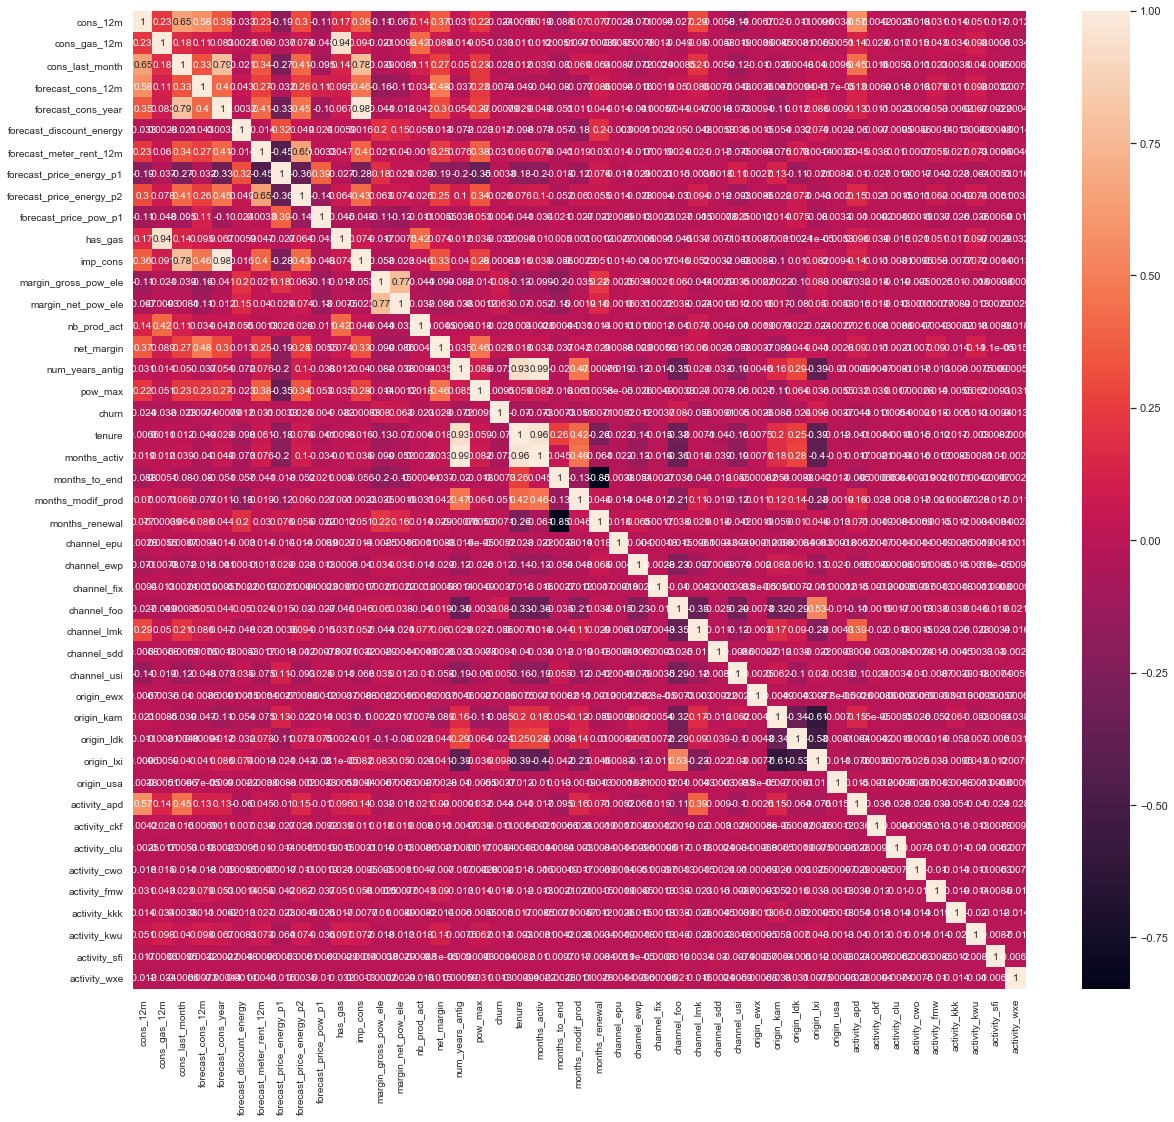

In [190]:
# Plot correlation
plt.figure(figsize=(20,18))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [191]:
# num_years_antig has a high correlation with months_activ (it provides us the same information).
# We can remove variables with very high correlation

train.drop(columns=["num_years_antig", "forecast_cons_year"],inplace=True)

3. Removing Outliers

What are the criteria to identify an outlier?

The most common way to identify an outlier are:
    
1. Data point that falls outside of 1.5 times of an interquartile range 
above the 3rd quartile and below the 1st quartile

OR

2. Data point that falls outside of 3 standard deviations.

Once, we have identified the outlier,There are several ways to handle with
those outliers such as removing them (this works well for massive datasets) or replacing them with sensible data
(works better when the dataset is not that big).

We will replace the outliers with the mean (average of the values excluding outliers).

In [128]:
def replace_outliers_z_score(dataframe, column, Z=3):
    """
 Replace outliers with the mean values using the Z score.
 Nan values are also replaced with the mean values.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """
    from scipy.stats import zscore
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    
    # Calculate mean without outliers
    df["zscore"] = zscore(df[column])
    mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()
    
    # Replace with mean values
    dataframe[column] = dataframe[column].fillna(mean_)
    dataframe["zscore"] = zscore(dataframe[column])
    no_outliers = dataframe[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z)].shape[0]
    dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_
    
    # Print message
    print("Replaced:", no_outliers, " outliers in ", column)
    return dataframe.drop(columns="zscore")


In [129]:
for c in features.columns:
    if c != "id":
        features = replace_outliers_z_score(features,c)

Replaced: 276  outliers in  mean_year_price_p1_var
Replaced: 0  outliers in  mean_year_price_p2_var
Replaced: 0  outliers in  mean_year_price_p3_var
Replaced: 120  outliers in  mean_year_price_p1_fix
Replaced: 0  outliers in  mean_year_price_p2_fix
Replaced: 0  outliers in  mean_year_price_p3_fix
Replaced: 122  outliers in  mean_year_price_p1
Replaced: 0  outliers in  mean_year_price_p2
Replaced: 0  outliers in  mean_year_price_p3


In [130]:
features.reset_index(drop=True, inplace=True)

In [192]:
def _find_outliers_iqr(dataframe, column):
    col = sorted(dataframe[column])
    q1, q3= np.percentile(col,[25,75])
    iqr = q3 - q1    
    lower_bound = q1 -(1.5 * iqr)
    upper_bound = q3 +(1.5 * iqr)
    results = {"iqr": iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
    return results

In [193]:
def remove_outliers_iqr(dataframe, column):
    outliers = _find_outliers_iqr(dataframe, column)
    removed = dataframe[(dataframe[column] < outliers["lower_bound"]) |
                        (dataframe[column] > outliers["upper_bound"])].shape
    
    dataframe = dataframe[(dataframe[column] > outliers["lower_bound"]) &
                          (dataframe[column] < outliers["upper_bound"])]
    
    print("Removed:", removed[0], " outliers")
    return dataframe

In [194]:
def remove_outliers_z_score(dataframe, column, Z=3):
    from scipy.stats import zscore
    dataframe["zscore"] = zscore(dataframe[column])
    removed = dataframe[(dataframe["zscore"] < -Z) |
                        (dataframe["zscore"] > Z)].shape
    
    dataframe = dataframe[(dataframe["zscore"] > -Z) &
                          (dataframe["zscore"] < Z)]
    
    print("Removed:", removed[0], " outliers of ", column)
    return dataframe.drop(columns="zscore")
    

In [195]:
train = replace_outliers_z_score(train,"cons_12m")
train = replace_outliers_z_score(train,"cons_gas_12m")
train = replace_outliers_z_score(train,"cons_last_month")
train = replace_outliers_z_score(train,"forecast_cons_12m")
#train = replace_outliers_z_score(train,"forecast_cons_year")
train = replace_outliers_z_score(train,"forecast_discount_energy")
train = replace_outliers_z_score(train,"forecast_meter_rent_12m")
train = replace_outliers_z_score(train,"forecast_price_energy_p1")
train = replace_outliers_z_score(train,"forecast_price_energy_p2")
train = replace_outliers_z_score(train,"forecast_price_pow_p1")
train = replace_outliers_z_score(train,"imp_cons")
train = replace_outliers_z_score(train,"margin_gross_pow_ele")
train = replace_outliers_z_score(train,"margin_net_pow_ele")
train = replace_outliers_z_score(train,"net_margin")
train = replace_outliers_z_score(train,"pow_max")
train = replace_outliers_z_score(train,"months_activ")
train = replace_outliers_z_score(train,"months_to_end")
train = replace_outliers_z_score(train,"months_modif_prod")
train = replace_outliers_z_score(train,"months_renewal")


Replaced: 174  outliers in  cons_12m
Replaced: 118  outliers in  cons_gas_12m
Replaced: 0  outliers in  cons_last_month
Replaced: 425  outliers in  forecast_cons_12m
Replaced: 575  outliers in  forecast_discount_energy
Replaced: 1  outliers in  forecast_meter_rent_12m
Replaced: 300  outliers in  forecast_price_energy_p1
Replaced: 0  outliers in  forecast_price_energy_p2
Replaced: 240  outliers in  forecast_price_pow_p1
Replaced: 0  outliers in  imp_cons
Replaced: 238  outliers in  margin_gross_pow_ele
Replaced: 220  outliers in  margin_net_pow_ele
Replaced: 185  outliers in  net_margin
Replaced: 293  outliers in  pow_max
Replaced: 462  outliers in  months_activ
Replaced: 2  outliers in  months_to_end
Replaced: 156  outliers in  months_modif_prod
Replaced: 133  outliers in  months_renewal


In [196]:
train.reset_index(drop=True, inplace=True)

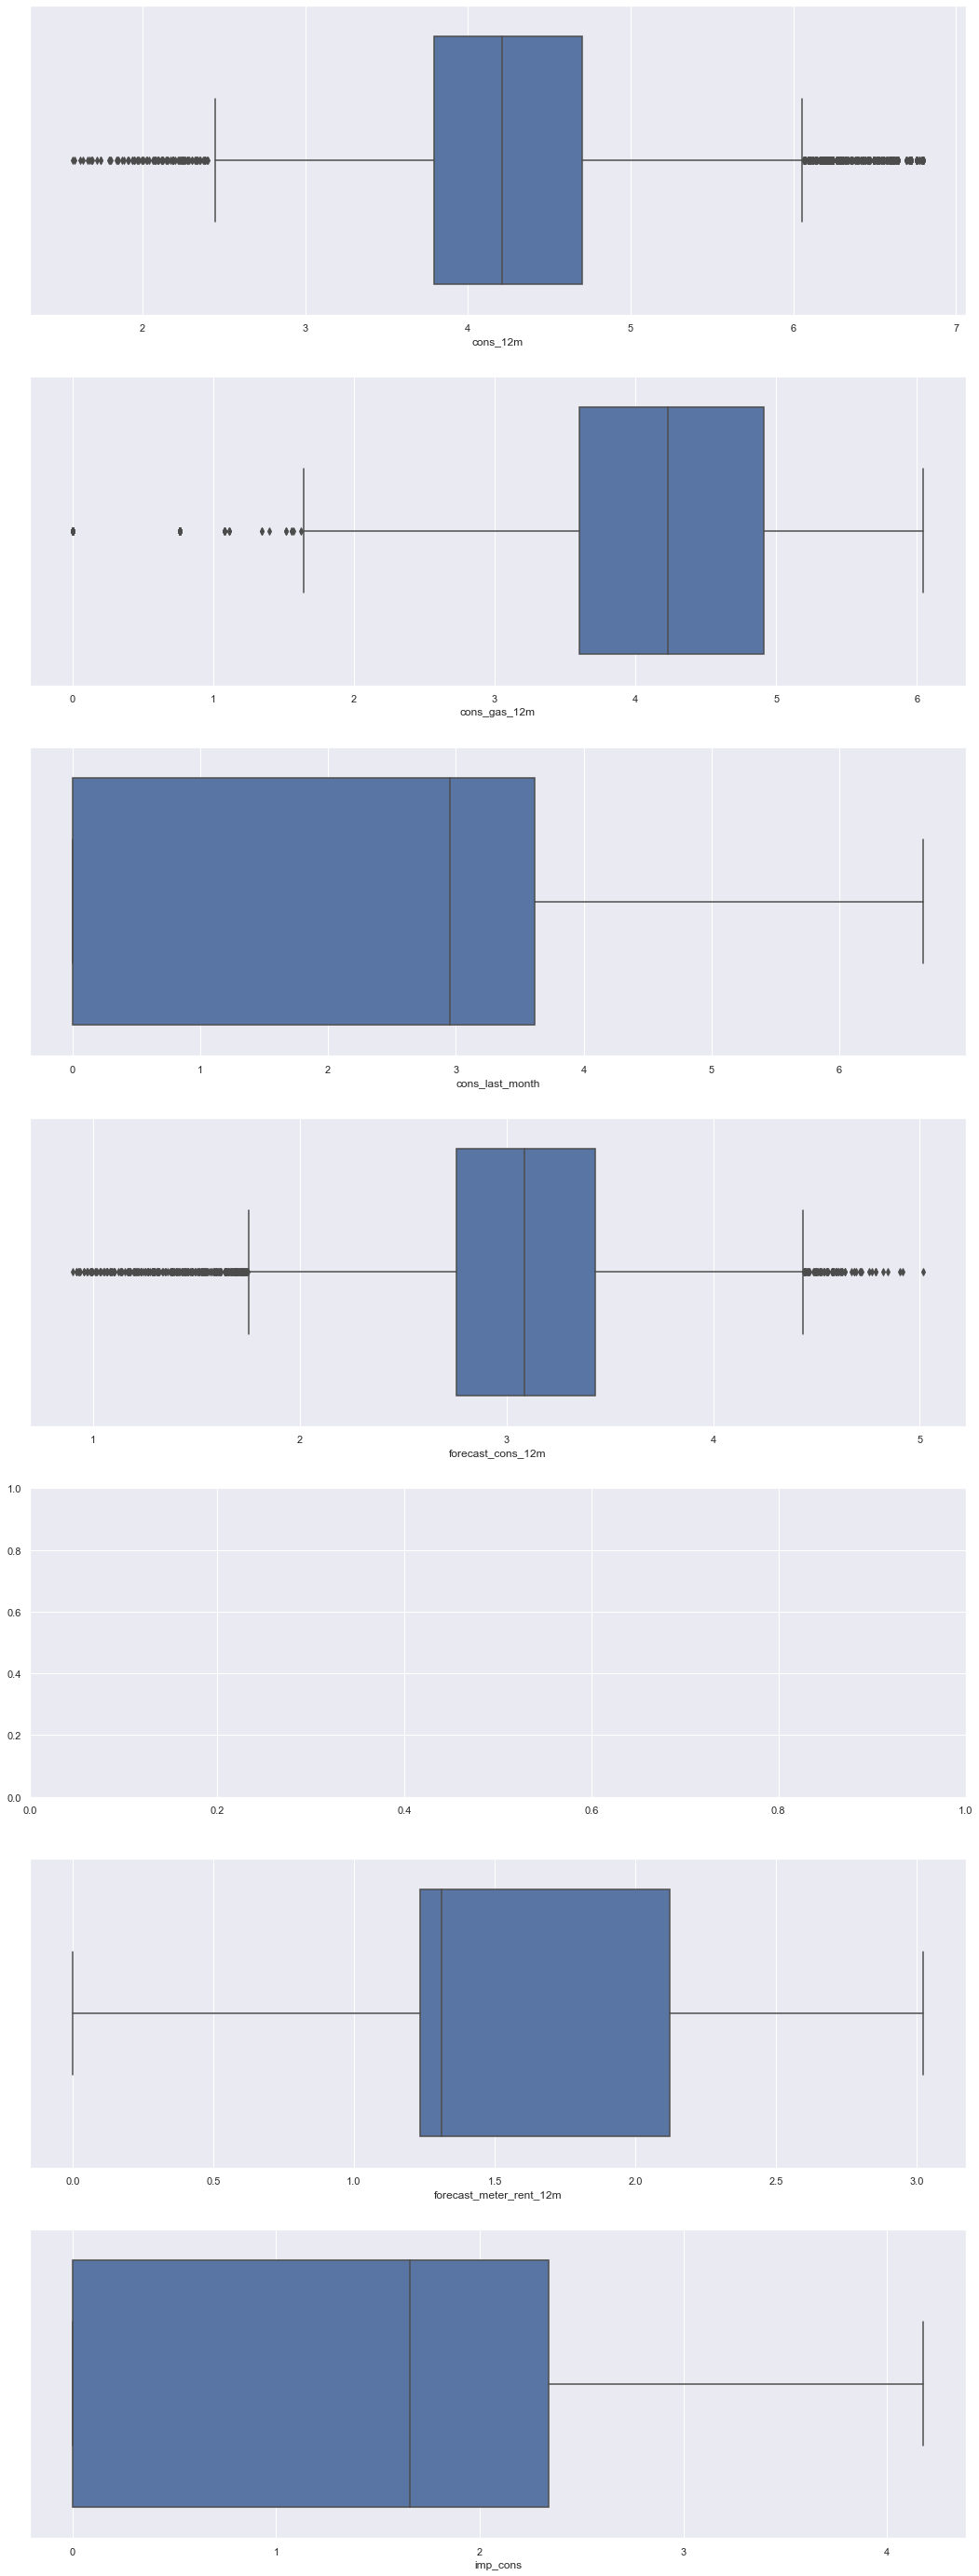

In [197]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
#sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [198]:
PICKLE_TRAIN_DIR_FE = os.path.join("C:/Users/saivi/Documents/BCG", "processed_data", "train_data.pkl")
PICKLE_HISTORY_DIR_FE = os.path.join("C:/Users/saivi/Documents/BCG", "processed_data", "history_data.pkl")


In [199]:
pd.to_pickle(train, PICKLE_TRAIN_DIR_FE)
pd.to_pickle(history_data, PICKLE_HISTORY_DIR_FE)